# POA update: Bayes vs. FSOR-method

Reference: _Updating probability of area_, Lars Pesch, 05.02.2018

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Input

In [2]:
n_segments = 10
n_search_tasks = 3 * n_segments # Total number of search assignments.
                                # Choose as fixed number if you like.
segmentation_covers = 'R75'     # The radius up to which the segmentation reaches out.
#
# Choose one of the two policies: either constant POD or uniformly random distribution
# in the given range.
#pod_policy = 'constant' ; pod_const = 0.8
pod_policy = 'random' ; pod_min = 0.4 ; pod_max = 0.9

## Declarations and initialization

In [3]:
p_Bayes = np.zeros((n_search_tasks+1, # index zero is for initial value
                    n_segments+1))    # index zero is for ROW
p_FSOR = np.zeros((n_search_tasks+1,
                   n_segments+1))

In [4]:
# Initial probabilities of area:
#
# For Bayes we assume that the segments cover everything out to segmentation_covers, i.e.
# ROW has the probability:
p_Bayes[0, 0] = 1. - float(segmentation_covers[1:]) / 100
# The rest of the probability is spread evenly over the other segments.
p_Bayes[0, 1:] = (1. - p_Bayes[0,0]) / n_segments
#
# For the FSOR method, ROW initially has zero probability and all segments are equal.
p_FSOR[0, 1:] = 1. / n_segments

In [5]:
# Predefine all PODs -- we know how good everyone will perform :-)
# Saves messing with this later.
if pod_policy == 'constant':
    pod = pod_const * np.ones(n_search_tasks)
elif pod_policy == 'random':
    np.random.seed(37)
    pod = np.random.uniform(low=pod_min, high=pod_max, size=n_search_tasks)
else:
    print('Unknown pod_policy!')

## Processing

In [6]:
# Update functions. For Bayes see the reference given above.
# Input: i_seg    index of the searched segment, 0-based, 0=ROW
#        pod      POD of the search task
#        p_old    POAs before the search task (len = n_segments+1)
# Returns: p_new  POAs after the search, same length as p_old
def update_Bayes(i_seg, pod, p_old):
    p_new = p_old / (1. - pod * p_old[i_seg])
    p_new[i_seg] *= (1. - pod)
    return p_new
def update_FSOR(i_seg, pod, p_old):
    p_new = p_old.copy()
    moved_pod = pod * p_old[i_seg]
    p_new[i_seg] -= moved_pod
    p_new[0] += moved_pod
    return p_new

In [7]:
segment_sequence_Bayes = []
segment_sequence_FSOR = []
for i_search_task in range(n_search_tasks):
    # Find the index of the segment with the highest POA (exclude ROW).
    i_seg_Bayes = 1 + np.argmax(p_Bayes[i_search_task, 1:])
    i_seg_FSOR  = 1 + np.argmax(p_FSOR[i_search_task, 1:])
    p_Bayes[i_search_task+1, :] = update_Bayes(i_seg_Bayes, pod[i_search_task],
                                               p_Bayes[i_search_task, :])
    p_FSOR[i_search_task+1, :] = update_FSOR(i_seg_FSOR, pod[i_search_task],
                                             p_FSOR[i_search_task, :])
    segment_sequence_Bayes.append(i_seg_Bayes)
    segment_sequence_FSOR.append(i_seg_FSOR)

## Postprocessing and plotting
Let's first check that the sum of the probabilities in every step is one. This should hold for both methods.

In [8]:
# If we subtract 1 from the sum along a column, is it nonzero?
print(np.round(np.sum(p_Bayes, axis=1) - np.ones(n_search_tasks+1), decimals=8).any())
print(np.round(np.sum(p_FSOR, axis=1) - np.ones(n_search_tasks+1), decimals=8).any())

False
False


So that was OK, the POAs always sum to one.

But the central question is: will the two methods yield the same search segment orders?

In [9]:
def print_seq(name, indices):
    print('{0:<5}:'.format(name), end='')
    for j in indices:
        print('{0:3d}'.format(j), sep=' ', end='')
    print()

print('Search segment index sequence for the two methods:')
print_seq('Bayes', segment_sequence_Bayes)
print_seq('FSOR', segment_sequence_FSOR)
print('Sequences equal:', segment_sequence_Bayes == segment_sequence_FSOR)

Search segment index sequence for the two methods:
Bayes:  1  2  3  4  5  6  7  8  9 10  7  3  9  2  4  5  6  8 10  9  5  3  1  7  5  6  3  8  1 10
FSOR :  1  2  3  4  5  6  7  8  9 10  7  3  9  2  4  5  6  8 10  9  5  3  1  7  5  6  3  8  1 10
Sequences equal: True


No! Actually they don't.

To understand that let's look a bit closer at the changes in the POA.

In [10]:
def plot_POA(poa):
    # Plot all POAs in a single plot; the y-axis on the left is for ROW,
    # the one on the right is for all other segments.
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(poa[:, 0])
    ax2.plot(poa[:, 1:])

    ax1.set_xlabel('i_search_task')
    ax1.set_ylabel('ROW')
    ax2.set_ylabel('segments')

    plt.show()

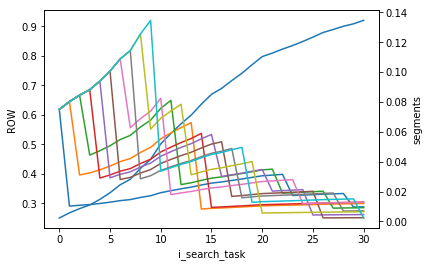

In [11]:
plot_POA(p_Bayes)
# Interpretation: as a segment is searched without finding, POA is reduced in the
# searched segment; the corresponding increase is spread over ROW AND the other
# segments.

So what happens? The first search reduces the POA of segment 1 (blue line). All other POAs start from the same value (hence one sees only one curve), and are slightly increased when the POA from segment 1 is given to the other segments and ROW. Already when segment 2 (orange POA-curve) is searched one can observe the effect that is responsible for the different sequences: compare the increase of the segment 1 POA with the increase of the other segments' POAs (and also the one for ROW). The increase for segment 1 is much less than for all the other segments. The reason for this can be found in formula (2.4): the new POA of the non-searched segments is the old POA divided by some number which is the same for all segments (and which is less than one). Therefore, segment 1, whose POA was reduced considerably by the first search task, receives a much smaller increase of POA (because it scales up the POA from before the current search task) than the other search segments, who have not yet been searched and therefore have higher POA values to start with. This is why the first part of the cyan curve rises faster than the lower part.

**BUT: the lower part curves are all upon each other, too!!! That the 2nd round starts with segment 7 may be just a matter of numerical roundoff!**

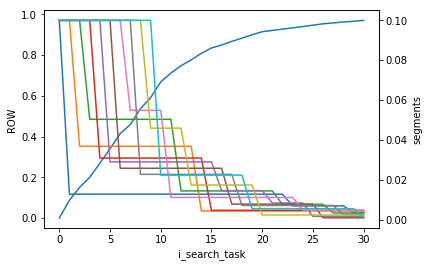

In [12]:
plot_POA(p_FSOR)
# Nothing unexpected here: searching one segment leaves the POA of the other ones
# unchanged, only ROW receives probability.